# Visualise the FathomNet Database

This notebook is used to download, analyze and process the data from the FathomNet Database.

In [ ]:
import matplotlib.pyplot as plt
import supervision as sv
from pathlib import Path
from datetime import datetime
import random

from fathomnet.api import boundingboxes, worms

## Download the Data

In [2]:
dataset_shortname = "fathomnet"
data_dir = Path("/tmp") / dataset_shortname
data_dir.mkdir(exist_ok=True, parents=True)
print(f"Data will be downloaded to {data_dir}")

Data will be downloaded to /tmp/fathomnet


In [3]:
# Choose the root concepts for fish
root_concepts = ["Actinopterygii", "Sarcopterygii", "Chondrichthyes", "Myxini"]
print(f"Root concepts: {', '.join(root_concepts)}\n")

# Get all descendants of the root concepts
fish_concepts = set(root_concepts)
for rc in root_concepts:
    descendant_concepts = worms.get_descendants_names(rc)
    fish_concepts.update(descendant_concepts)
    print(f"Added {len(descendant_concepts)} descendants of {rc}")

# Find annotated concepts in FathomNet
fathomnet_concepts = set(boundingboxes.find_concepts())

# Compute the intersection of fish concepts and FathomNet concepts
fish_concepts_in_fathomnet = fish_concepts & fathomnet_concepts
print(f"\nFound {len(fish_concepts_in_fathomnet)} fish concepts in FathomNet")

# Write the fish concepts to a file
fish_concepts_file = data_dir / "concepts.txt"
with fish_concepts_file.open("w") as f:
    f.write("\n".join(sorted(fish_concepts_in_fathomnet)))
print(f"Wrote selected concepts to {fish_concepts_file}")

Root concepts: Actinopterygii, Sarcopterygii, Chondrichthyes, Myxini

Added 101437 descendants of Actinopterygii
Added 50 descendants of Sarcopterygii
Added 4620 descendants of Chondrichthyes
Added 174 descendants of Myxini

Found 488 fish concepts in FathomNet
Wrote selected concepts to /tmp/fathomnet/concepts.txt


In [4]:
today = datetime.now().strftime("%Y.%m.%d")
annotations_path = data_dir / f"fathomnet-{today}.json"
images_path = data_dir / "images"
print(f"Annotations will be saved to {annotations_path}")
print(f"Images will be downloaded to {images_path}")

Annotations will be saved to /tmp/fathomnet/fathomnet-2025.02.12.json
Images will be downloaded to /tmp/fathomnet/images


In [7]:
# Download images and annotations
!fathomnet-generate -v \
    --format coco \
    --concepts-file {fish_concepts_file} \
    --output {data_dir} \
    --img-download {images_path} \
    && \
    mv {data_dir / "dataset.json"} {annotations_path}

INFO:root:Successfully parsed flags
INFO:root:Concept(s) specified:
INFO:root:- Abyssoberyx
INFO:root:- Acanthonus armatus
INFO:root:- Acanthurus xanthopterus
INFO:root:- Actinopteri
INFO:root:- Actinopterygii
INFO:root:- Agonidae
INFO:root:- Albatrossia
INFO:root:- Albatrossia pectoralis
INFO:root:- Aldrovandia
INFO:root:- Aldrovandia affinis
INFO:root:- Aldrovandia phalacra
INFO:root:- Aldrovandia rostrata
INFO:root:- Alepisaurus ferox
INFO:root:- Alepocephalidae
INFO:root:- Alepocephalus
INFO:root:- Alepocephalus tenebrosus
INFO:root:- Alopias superciliosus
INFO:root:- Amblyraja hyperborea
INFO:root:- Anarrhichthys ocellatus
INFO:root:- Anguilliformes
INFO:root:- Anoplogaster cornuta
INFO:root:- Anoplopoma fimbria
INFO:root:- Anotopterus nikparini
INFO:root:- Antigonia
INFO:root:- Antimora
INFO:root:- Antimora microlepis
INFO:root:- Aphanopus
INFO:root:- Aphyonidae
INFO:root:- Apogon pacificus
INFO:root:- Apristurus
INFO:root:- Apristurus brunneus
INFO:root:- Apristurus kampae
INFO:

### Clean the annotations
Turn into COCO format readable by `supervision` library, for easy visualization and conversion to other formats.
- annotations.json only contains annotations for images with at least one bounding box

In [8]:
import json

with open(annotations_path, "r") as f:
    annotations = json.load(f)

cleaned_annotations = []

print(f"Number of annotations: {len(annotations['annotations'])}")
    
for i, annotation in enumerate(annotations["annotations"]):
    if "bbox" not in annotation or len(annotation["bbox"]) == 0:
        print(f"No bbox found for {annotation['image_id']}")
    else:
        cleaned_annotations.append(annotation)

annotations["annotations"] = cleaned_annotations

with open(annotations_path, "w") as f:
    print(f"Number of annotations: {len(annotations['annotations'])}")
    json.dump(annotations, f)


Number of annotations: 36899
Number of annotations: 36899


## Visualise
To visualise we need to extract the frames from the video, therefore, pick only one video to analyse


In [9]:
dataset = sv.DetectionDataset.from_coco(
    images_directory_path=str(images_path),
    annotations_path=str(annotations_path),
)

print(f"Dataset length: {len(dataset)}")
print(f"Dataset classes: {dataset.classes}")

Dataset length: 22260
Dataset classes: ['Abyssoberyx', 'Acanthonus armatus', 'Acanthurus xanthopterus', 'Actinopteri', 'Actinopterygii', 'Agonidae', 'Albatrossia', 'Albatrossia pectoralis', 'Aldrovandia', 'Aldrovandia affinis', 'Aldrovandia phalacra', 'Aldrovandia rostrata', 'Alepisaurus ferox', 'Alepocephalidae', 'Alepocephalus', 'Alepocephalus tenebrosus', 'Alopias superciliosus', 'Amblyraja hyperborea', 'Anarrhichthys ocellatus', 'Anguilliformes', 'Anoplogaster cornuta', 'Anoplopoma fimbria', 'Anotopterus nikparini', 'Antigonia', 'Antimora', 'Antimora microlepis', 'Aphanopus', 'Aphyonidae', 'Apogon pacificus', 'Apristurus', 'Apristurus brunneus', 'Apristurus kampae', 'Ariomma', 'Aristeus', 'Astronesthes', 'Barathrites', 'Barathronus', 'Barbourisia rufa', 'Bassogigas', 'Bassogigas walkeri', 'Bassozetus', 'Bassozetus nasus', 'Bathyagonus nigripinnis', 'Bathycongrus', 'Bathycongrus macrurus', 'Bathylagidae', 'Bathylagus', 'Bathyphylax pruvosti', 'Bathypterois', 'Bathypterois atricolor'

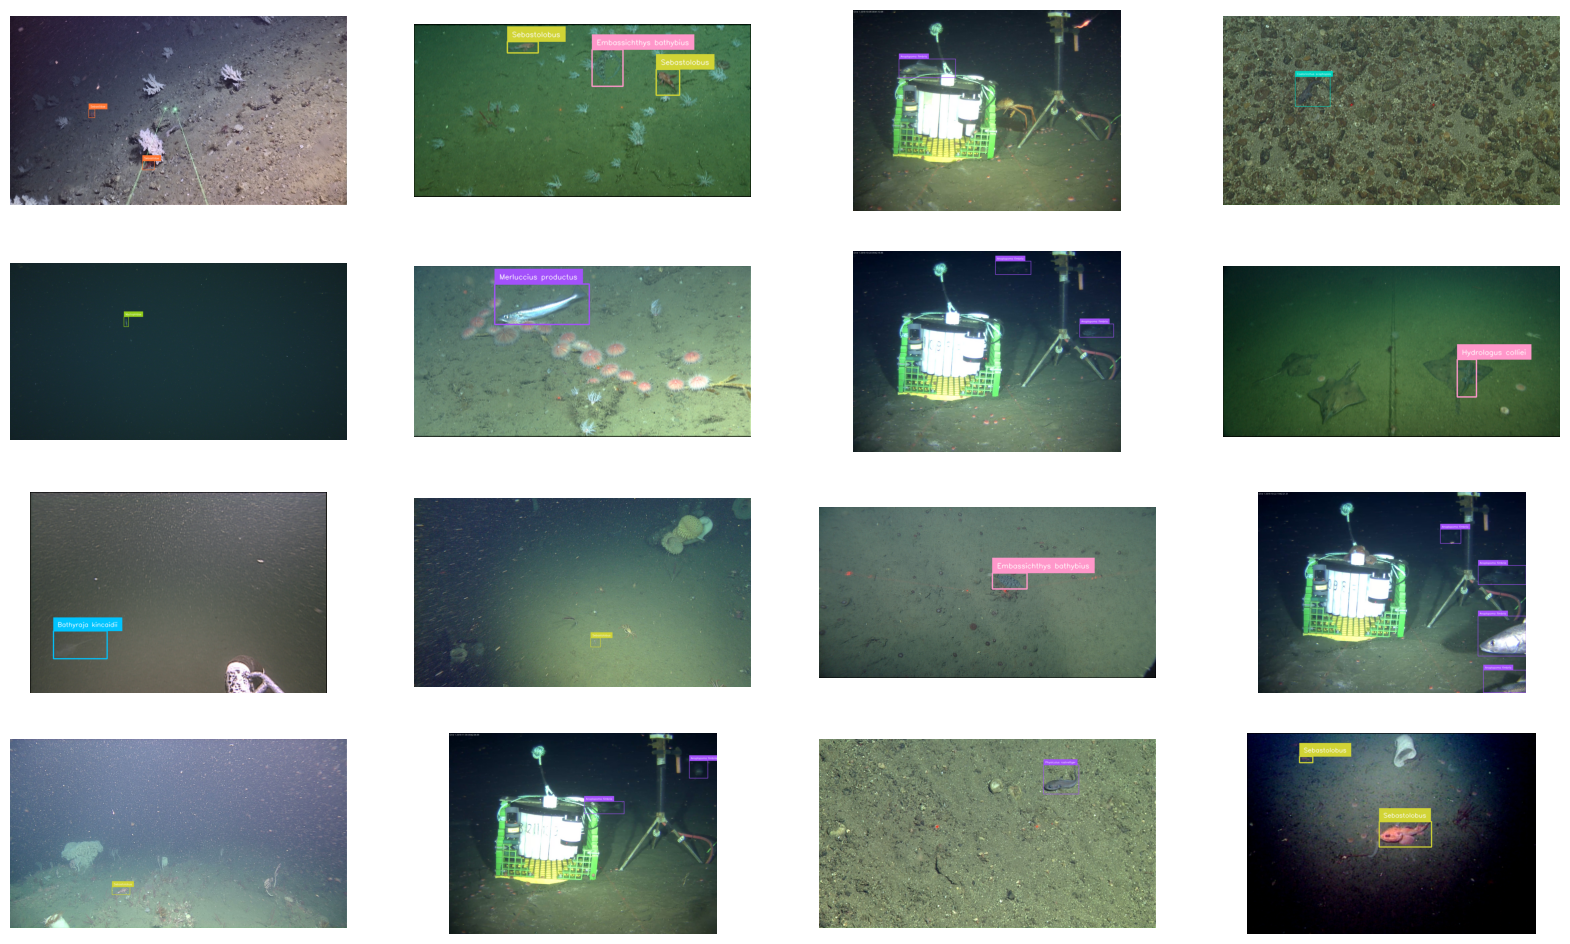

In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

image_example = None

annotated_images = []
for _ in range(16):
    i = random.randint(0, len(dataset))
    
    _, image, annotations = dataset[i]

    labels = [dataset.classes[class_id] for class_id in annotations.class_id]

    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels)
    annotated_images.append(annotated_image)
    
    if len(annotations) > 0:
        image_example = annotated_image
    
sv.plot_images_grid(
    annotated_images,
    grid_size=(4, 4),
    titles=None,
    size=(20, 12),
    cmap="gray"
)

image_example = image_example[..., ::-1]  # BGR to RGB
plt.imsave(f"data_preview/{dataset_shortname}_sample_image.png", image_example)
